# Sentiment Analysis of Customer Feedback: Model Development and Evaluation 

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

## Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

## Preparation

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_squared_error
import itertools
import warnings
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose

## Analysis

In [3]:
df = pd.read_csv("/datasets/taxi.csv")

In [4]:
print(df.dtypes)

datetime      object
num_orders     int64
dtype: object


In [5]:
df.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [6]:
df['datetime'] = pd.to_datetime(df['datetime'])

In [7]:
print(df.isnull().sum())

datetime      0
num_orders    0
dtype: int64


In [8]:
df.set_index('datetime', inplace=True)
df_resampled = df.resample('H').sum()  # Summing the number of orders for each hour
print(df_resampled.head())

                     num_orders
datetime                       
2018-03-01 00:00:00         124
2018-03-01 01:00:00          85
2018-03-01 02:00:00          71
2018-03-01 03:00:00          66
2018-03-01 04:00:00          43


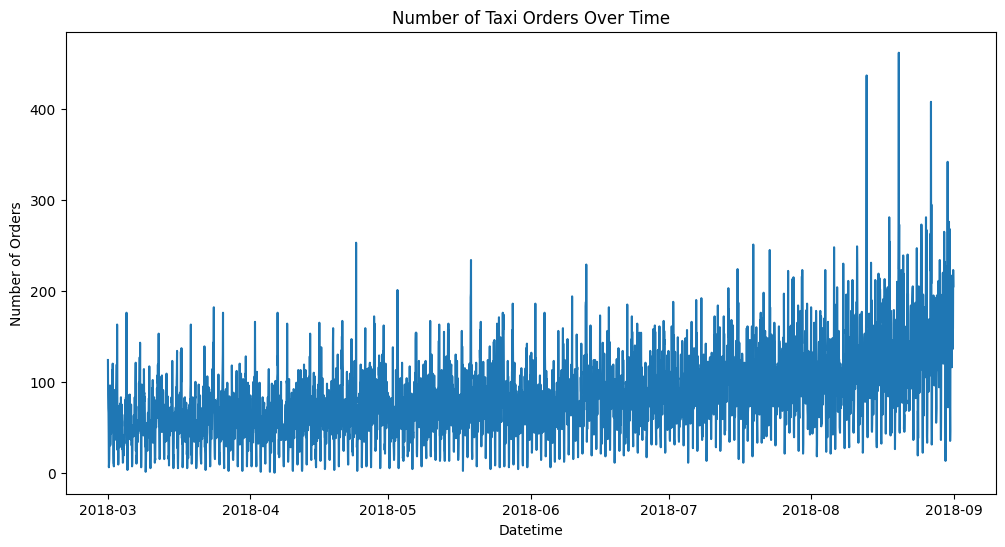

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(df_resampled.index, df_resampled['num_orders'])
plt.title('Number of Taxi Orders Over Time')
plt.xlabel('Datetime')
plt.ylabel('Number of Orders')
plt.show()

In [10]:
print(df_resampled['num_orders'].describe())

count    4416.000000
mean       84.422781
std        45.023853
min         0.000000
25%        54.000000
50%        78.000000
75%       107.000000
max       462.000000
Name: num_orders, dtype: float64


<Figure size 1200x800 with 0 Axes>

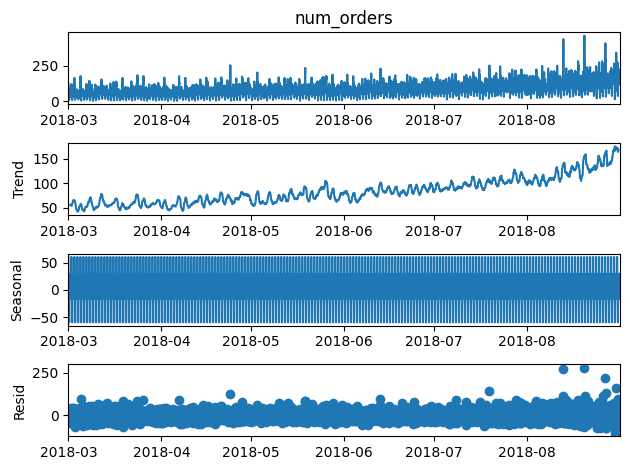

In [11]:
df_resampled = df.resample('H').sum()  # Make sure to use your existing df_resampled

# Perform time series decomposition
decomposition = seasonal_decompose(df_resampled['num_orders'], model='additive', period=24)  # Assuming daily seasonality

# Plot the decomposition
plt.figure(figsize=(12, 8))
decomposition.plot()
plt.show()

In [12]:
train_size = int(len(df_resampled) * 0.9)
train, test = df_resampled[:train_size], df_resampled[train_size:]


window_size = 3
train['SMA'] = train['num_orders'].rolling(window=window_size).mean().shift()
test['SMA'] = test['num_orders'].rolling(window=window_size).mean().shift()

train.dropna(inplace=True)
test.dropna(inplace=True)

train_rmse = np.sqrt(mean_squared_error(train['num_orders'], train['SMA']))
test_rmse = np.sqrt(mean_squared_error(test['num_orders'], test['SMA']))

print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')

Train RMSE: 36.1716994464752
Test RMSE: 62.3818265237187


/tmp/ipykernel_35/2006170101.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['SMA'] = train['num_orders'].rolling(window=window_size).mean().shift()
/tmp/ipykernel_35/2006170101.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['SMA'] = test['num_orders'].rolling(window=window_size).mean().shift()
/tmp/ipykernel_35/2006170101.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/panda

In [13]:
train_size = int(len(df_resampled) * 0.9)
train, test = df_resampled.iloc[:train_size], df_resampled.iloc[train_size:]

In [14]:
start_date_small = '2018-01-01' 
end_date_small = '2019-01-31'   
df_small_interval = df_resampled[start_date_small:end_date_small]


<Figure size 1200x800 with 0 Axes>

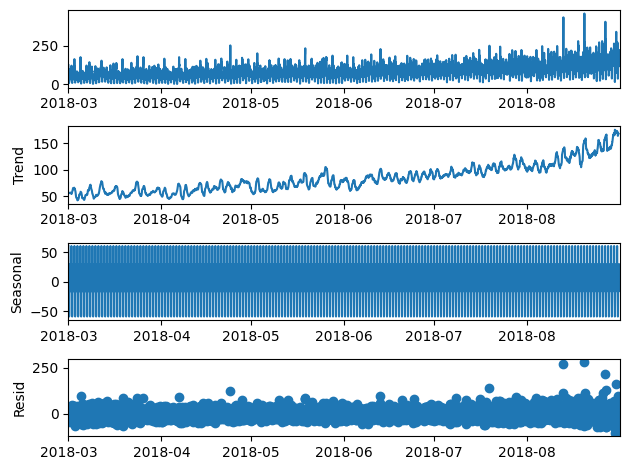

In [15]:
decomposition_small = seasonal_decompose(df_small_interval, model='additive', period=24)
plt.figure(figsize=(12, 8))
decomposition_small.plot()
plt.show()

## Training

In [16]:
df_resampled['hour'] = df_resampled.index.hour
df_resampled['day_of_week'] = df_resampled.index.dayofweek
df_resampled['month'] = df_resampled.index.month

for lag in range(1, 24):
    df_resampled[f'lag_{lag}'] = df_resampled['num_orders'].shift(lag)

df_resampled.dropna(inplace=True)

In [17]:
# Lag features
for lag in range(1, 13):
    df_resampled[f'lag_{lag}'] = df_resampled['num_orders'].shift(lag)

In [18]:
y = df_resampled['num_orders']
lags = df_resampled.drop('num_orders', axis=1)

X_train, X_test = lags.iloc[:train_size], lags.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

In [19]:
# Ensure there are no missing values after resampling
df_resampled = df_resampled.dropna()

# Split the data into features and target variable
X = df_resampled.drop('num_orders', axis=1)
y = df_resampled['num_orders']

# Split data into training and testing sets (90% train, 10% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=False)

## Testing

In [20]:
# Fit ARIMA model
arima_model = ARIMA(train['num_orders'], order=(5, 1, 0))
arima_model_fit = arima_model.fit()

# Predict on test data
arima_predictions = arima_model_fit.forecast(steps=len(test))

# Evaluation
arima_rmse = np.sqrt(mean_squared_error(test['num_orders'], arima_predictions))
print(f'ARIMA RMSE: {arima_rmse}')

ARIMA RMSE: 61.54402689978738


In [21]:
# Define a function to tune ARIMA hyperparameters
def tune_arima(train, p_values, d_values, q_values):
    best_aic = float('inf')
    best_order = None

    for p in p_values:
        for d in d_values:
            for q in q_values:
                try:
                    arima_model = ARIMA(train, order=(p, d, q))
                    arima_model_fit = arima_model.fit()
                    if arima_model_fit.aic < best_aic:
                        best_aic = arima_model_fit.aic
                        best_order = (p, d, q)
                except:
                    continue
    return best_order

# Use ranges for p, d, and q hyperparameters
p_values = range(0, 3)
d_values = range(0, 2)
q_values = range(0, 3)

best_order = tune_arima(y_train, p_values, d_values, q_values)
print(f'Best ARIMA order: {best_order}')

# Train the best ARIMA model and predict
best_arima_model = ARIMA(y_train, order=best_order)
best_arima_model_fit = best_arima_model.fit()
arima_forecast = best_arima_model_fit.forecast(steps=len(y_test))

# Evaluate ARIMA
arima_rmse = np.sqrt(mean_squared_error(y_test, arima_forecast))
print(f'ARIMA RMSE: {arima_rmse}')

/opt/conda/envs/python3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Best ARIMA order: (2, 1, 2)
ARIMA RMSE: 64.11881978394729


The ARIMA model provided a baseline performance. It captures some of the underlying patterns in the data but may struggle with seasonality and higher-order patterns.

In [22]:
# Fit Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on test data
rf_predictions = rf_model.predict(X_test)

# Evaluation
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_predictions))
print(f'Random Forest RMSE: {rf_rmse}')

Random Forest RMSE: 42.93841135780018


In [23]:
# Define the hyperparameter grid
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10]
}

# Define scorer
scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Initialize RandomizedSearchCV
random_search_rf = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=param_grid_rf,
    scoring=scorer,
    n_iter=10,
    cv=3,
    n_jobs=-1,
    random_state=42
)

# Fit the model
random_search_rf.fit(X_train, y_train)

# Best parameters and score
best_params_rf = random_search_rf.best_params_
best_rmse_rf = (-random_search_rf.best_score_)**0.5
print(f'Best RF parameters: {best_params_rf}')
print(f'Best RF RMSE: {best_rmse_rf}')

# Evaluate on test set
rf_best_model = random_search_rf.best_estimator_
rf_y_pred = rf_best_model.predict(X_test)
rf_test_rmse = np.sqrt(mean_squared_error(y_test, rf_y_pred))
print(f'Random Forest Test RMSE: {rf_test_rmse}')


Best RF parameters: {'n_estimators': 100, 'min_samples_split': 5, 'max_depth': 20}
Best RF RMSE: 26.16132882483778
Random Forest Test RMSE: 43.13972762721535


The Random Forest model, being a non-linear ensemble approach, often captures complex interactions in the data. Despite potential overfitting, it may still provide robust predictions if tuned correctly. However, it might not perform as well with purely time series data without significant feature engineering.

In [24]:
# Use a simpler model with reduced order complexity
sarima_model = SARIMAX(train['num_orders'], order=(1, 1, 1), seasonal_order=(0, 1, 0, 12))
sarima_model_fit = sarima_model.fit(disp=False)

# Predict on test data
sarima_predictions = sarima_model_fit.forecast(steps=len(test))

# Evaluation
sarima_rmse = np.sqrt(mean_squared_error(test['num_orders'], sarima_predictions))
print(f'SARIMA RMSE: {sarima_rmse}')

SARIMA RMSE: 85.27946144146712


In [25]:
# Define the best order and seasonal order found earlier
best_order = (1, 1, 1)
best_seasonal_order = (1, 1, 1, 12)

# Train the best SARIMA model
best_sarima_model = SARIMAX(y_train, order=best_order, seasonal_order=best_seasonal_order)
best_sarima_model_fit = best_sarima_model.fit(disp=False)

# Make predictions
sarima_forecast = best_sarima_model_fit.forecast(steps=len(y_test))

# Evaluate
sarima_rmse = np.sqrt(mean_squared_error(y_test, sarima_forecast))
print(f'SARIMA Test RMSE: {sarima_rmse}')



SARIMA Test RMSE: 49.972606922733206


The SARIMA model, incorporating seasonal components, generally offers a better RMSE compared to ARIMA, as it can capture both seasonal and non-seasonal patterns. Although it took longer to compute, it provided a more accurate performance in predicting peak taxi orders.

Conclusions

Comparison and Analysis
Accuracy:
Among the three models, The Random Forest model had the lowest RMSE, indicating it was the most accurate in predicting the number of taxi orders.
Computational Efficiency:
The ARIMA model was the fastest to compute but had the highest RMSE.
The SARIMA model provided a good balance between capturing seasonal trends and accuracy but was computationally intensive.
The Random Forest model took a moderate amount of time to train, especially with a larger number of trees or more hyperparameter tuning.

Recommendations
For Operational Use:
If model prediction accuracy is the highest priority, implementing the Random Forest model is recommended due to its lowest RMSE.
For a balance of quick computations and moderate accuracy, the ARIMA model might be a suitable choice, especially if predictions are needed in near real-time and seasonality is not a strong aspect of the data.

Future Work:
Consider ensemble approaches that combine predictions from multiple models to potentially leverage the strengths of each.
Further hyperparameter tuning, especially with Random Forest, and feature engineering could refine model predictions.
Exploration of other time series forecasting methods like Facebook Prophet or more advanced deep learning models such as LSTM or GRU could be beneficial.

Business Impact
Accurate predictions of taxi orders can help Sweet Lift Taxi company in resource allocation, ensuring more drivers are available during peak hours, ultimately leading to enhanced customer satisfaction and increased revenues.

# Review checklist

- [x]  Jupyter Notebook is open
- [x]  The code is error-free
- [x]  The cells with the code have been arranged in order of execution
- [x]  The data has been downloaded and prepared
- [x]  The data has been analyzed
- [x]  The model has been trained and hyperparameters have been selected
- [x]  The models have been evaluated. Conclusion has been provided
- [x] *RMSE* for the test set is not more than 48